In [30]:
import pickle
import numpy as np
import rewardpredictive as rp
import rlutils as rl
import matplotlib.pyplot as plt
from pathlib import Path
from rewardpredictive.mdp import RandomRewardChange, mdp_goal_dist, FixedTerminalRewardChange

from matplotlib import rc
rc('font', **{'family': 'serif', 'size': 9})
rc('text', usetex=True)

from definitions import ROOT_DIR

results_directory = 'UniformRandomResults'
# maze_file = Path(ROOT_DIR, 'data', 'RandomRewardMaze', 'Extra Mazes', 'upper_maze.pkl')
maze_file = Path(ROOT_DIR, 'data', 'RandomRewardMaze', 'maze.pkl')

ql = rp.ExperimentSetTaskSequenceRandomRewardChangeQLearning.load(base_dir=f'./data/{results_directory}')
qt = rp.ExperimentSetTaskSequenceRandomRewardChangeQTransfer.load(base_dir=f'./data/{results_directory}')
sfl = rp.ExperimentSetTaskSequenceRandomRewardChangeSFLearning.load(base_dir=f'./data/{results_directory}')
sft = rp.ExperimentSetTaskSequenceRandomRewardChangeSFTransfer.load(base_dir=f'./data/{results_directory}') 
sfta = rp.ExperimentSetTaskSequenceRandomRewardChangeSFTransferAll.load(base_dir=f'./data/{results_directory}')

with open(maze_file, 'rb') as f:
    mdp_seq = pickle.load(f)


In [40]:
for sf in [sfl, sft, sfta]:
    for i, exp in enumerate(sf.experiment_list):
        if exp.hparam['lr_r'] > 0.5 or exp.hparam['lr_sf'] > 0.5:
            del sf.experiment_list[i]

for q in [ql, qt]:
    for i, exp in enumerate(q.experiment_list):
        if exp.hparam['lr'] > 0.5:
            del q.experiment_list[i]


In [41]:
from rlutils.environment.gridworld import idx_to_pt
    
sample_mdp = mdp_seq[0]
sm = sample_mdp.size_maze

if not hasattr(mdp_seq[0], 'goal_position'):
    for mdp in mdp_seq:
        mdp.goal_position = idx_to_pt(mdp.goal_state_list()[0], (sm, sm))

all_positions = [mdp_seq[0].goal_position]

all_distances = [0]
for i in range(1, len(mdp_seq)):
    all_distances.append(int(mdp_goal_dist(mdp_seq[i-1], mdp_seq[i])))
    all_positions.append(mdp_seq[i].goal_position)
all_distances

[0, 3, 4, 4, 0, 6, 0, 3, 5, 8, 6, 3, 2, 6, 3, 2, 3, 4, 11, 7]

In [42]:
print('Q-learning')
exp_ql = ql.get_best_experiment(exploration='egreedy', task_sequence='significant') 
print('Q-learning with Q-value transfer')
exp_qt = qt.get_best_experiment(exploration='egreedy', task_sequence='significant')  
print('SF-transfer')
exp_sft = sft.get_best_experiment(exploration='egreedy', task_sequence='significant')  
print('SF-learning')
exp_sfl = sfl.get_best_experiment(exploration='egreedy', task_sequence='significant')  
print('SF-learning with SF and rew transfer')
exp_sfta = sfta.get_best_experiment(exploration='egreedy', task_sequence='significant')  

# Set up some preliminary variables used for plotting
episodes_per_task = exp_ql.results['episode_length'][0].shape[-1]
runs_per_task = len(exp_ql.results['episode_length'])
num_tasks = exp_ql.results['episode_length'][0].shape[0]
tasks = np.arange(num_tasks)


Q-learning
repeats: 10
task_sequence: significant
exploration: egreedy
episodes: 200
epsilon: 0.1
gamma: 0.99
mdp_size: 8
num_tasks: 20
lr: 0.3
Q-learning with Q-value transfer
repeats: 10
task_sequence: significant
exploration: egreedy
episodes: 200
epsilon: 0.1
gamma: 0.99
mdp_size: 8
num_tasks: 20
lr: 0.5
SF-transfer
repeats: 10
task_sequence: significant
exploration: egreedy
episodes: 200
epsilon: 0.1
gamma: 0.99
mdp_size: 8
num_tasks: 20
lr_sf: 0.1
lr_r: 0.5
SF-learning
repeats: 10
task_sequence: significant
exploration: egreedy
episodes: 200
epsilon: 0.1
gamma: 0.99
mdp_size: 8
num_tasks: 20
lr_sf: 0.5
lr_r: 0.3
SF-learning with SF and rew transfer
repeats: 10
task_sequence: significant
exploration: egreedy
episodes: 200
epsilon: 0.1
gamma: 0.99
mdp_size: 8
num_tasks: 20
lr_sf: 0.3
lr_r: 0.5


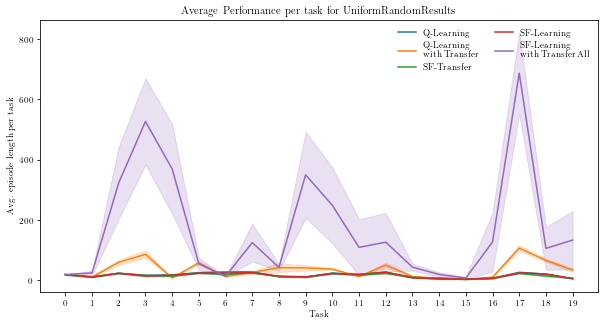

In [43]:
ep_len_qlearning = np.mean(np.array(exp_ql.results['episode_length']), axis=-1)
ep_len_qtransfer = np.mean(np.array(exp_qt.results['episode_length']), axis=-1)
ep_len_sftransfer = np.mean(np.array(exp_sft.results['episode_length']), axis=-1)
ep_len_sflearning = np.mean(np.array(exp_sfl.results['episode_length']), axis=-1)
ep_len_sftransferall = np.mean(np.array(exp_sfta.results['episode_length']), axis=-1)

plt.figure(figsize=(10, 5))
rl.plot.mean_with_sem(tasks, ep_len_qlearning, axis=0, color='C0', label='Q-Learning')
rl.plot.mean_with_sem(tasks, ep_len_qtransfer, axis=0, color='C1', label='Q-Learning\nwith Transfer')
rl.plot.mean_with_sem(tasks, ep_len_sftransfer, axis=0, color='C2', label='SF-Transfer')
rl.plot.mean_with_sem(tasks, ep_len_sflearning, axis=0, color='C3', label='SF-Learning')
rl.plot.mean_with_sem(tasks, ep_len_sftransferall, axis=0, color='C4', label='SF-Learning\nwith Transfer All')

# plt.ylim([10, 35])
plt.title(f'Average Performance per task for {results_directory}')
plt.ylabel('Avg. episode length per task')
plt.xlabel('Task')
plt.xticks(tasks)
leg = plt.legend(loc=1, ncol=2, frameon=False)
leg.get_frame().set_linewidth(0.0)
plt.savefig('figure/sftransfer/comparison_ep_len_per_task.pdf', bbox_inches='tight', pad_inches=.1, transparent=True)

In [ ]:
import numpy as np
from scipy.stats import sem

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def mean_with_sem(xvals, yvals, axis=0, color='C0', label=None):  # pragma: no cover
    import matplotlib.pyplot as plt # Must be imported on use, otherwise matplotlib may open a UI window.

    yvals_m = np.mean(yvals, axis=axis)
#     yvals_m = smooth(yvals_m, 10)
    yvals_m = yvals_m

    yvals_e = sem(yvals, axis=axis)
    plt.plot(xvals, yvals_m, c=color, label=label)
    plt.fill_between(xvals, y1=yvals_m + yvals_e, y2=yvals_m - yvals_e, color=color, alpha=0.2)

y_lim = 1000

plt.figure(figsize=(20, 6))
# i = 1
for i, j in [(episodes_per_task * task, task) for task in tasks]:
    plt.plot([i, i], [0, 1000], c='k', alpha=0.5)
    plt.text(i - 15, y_lim - 2, all_distances[j])

ep_len_ql = np.array(exp_ql.results['episode_length']).transpose([1, 0, 2])
ep_len_qt = np.array(exp_qt.results['episode_length']).transpose([1, 0, 2])
ep_len_sfl = np.array(exp_sfl.results['episode_length']).transpose([1, 0, 2])
ep_len_sft = np.array(exp_sft.results['episode_length']).transpose([1, 0, 2])
ep_len_sfta = np.array(exp_sfta.results['episode_length']).transpose([1, 0, 2])
ep_idx = np.arange(100) + 1
# exp_names = ["Q-learning", "Q-Learning with Transfer", "SF-Learning", "SF-Tranfer", "SF-TransferAll"]
# for j, ep in enumerate([ep_len_ql, ep_len_qt, ep_len_sfl, ep_len_sft, ep_len_sfta]):
exp_names = ["Q-learning", "Q-Learning with Transfer", "SF-Tranfer", "SF-TransferAll"]
for j, ep in enumerate([ep_len_ql, ep_len_qt, ep_len_sft, ep_len_sfta]):
    for i, ep_len in enumerate(ep):
        mean_with_sem(ep_idx + i * 100, ep_len, axis=0, color=f'C{j}', label=exp_names[j] if i == 0 else "")
    
#     mean_with_sem(ep_idx + i * 100, ep[i], axis=0, color=f'C{j}', label=exp_names[j])

# plt.xticks([0] + list(np.arange(episodes_per_task, (episodes_per_task * num_tasks + 1), episodes_per_task)))
plt.xlabel('Episode')
plt.ylabel('Avg. Episode Length')
plt.ylim([0, y_lim])
plt.title(f'Average Episode length over episodes for {results_directory}')
leg = plt.legend(loc=1, ncol=2, frameon=False)
leg.get_frame().set_linewidth(0.0)
plt.savefig('figure/sftransfer/sf_transfer_ep_len.pdf', bbox_inches='tight', pad_inches=.1, transparent=True)

In [ ]:
{
    "Q-Learning": ep_len_qlearning.mean(),
    "Q-Transfer": ep_len_qtransfer.mean(),
    "SF-Transfer": ep_len_sftransfer.mean(),
    "SF-Learning": ep_len_sflearning.mean(),
    "SF-TransferAll": ep_len_sftransferall.mean()
}

In [ ]:
# HYPERPARAMETER SENSITIVITY PLOTSplt.figure(figsize=(10, 5))
hyperparam = "lr"

def get_hp_results(exp_set, hyperparam):
    variants = []
    full_results = []
    averages = []
    for exp in exp_set.experiment_list:
        variants.append(exp.hparam[hyperparam])
        data = np.array(exp.results['episode_length'])
        full_results.append(data)
        averages.append(np.average(data, axis=(-2, -1)))
    
    return variants, averages, full_results

variants, ql_averages, _ = get_hp_results(ql, hyperparam)
_, qt_averages, _ = get_hp_results(qt, hyperparam)
# _, sft_averages, _ = get_hp_results(sft, hyperparam)
# _, sfl_averages, _ = get_hp_results(sfl, hyperparam)
# _, sfta_averages, _ = get_hp_results(sfta, hyperparam)


plt.figure(figsize=(10, 5))
rl.plot.mean_with_sem(variants, ql_averages, axis=1, color='C0', label='Q-Learning')
rl.plot.mean_with_sem(variants, qt_averages, axis=1, color='C1', label='Q-Learning\nwith Transfer')
# # rl.plot.mean_with_sem(variants, sft_averages, axis=0, color='C2', label='SF-Transfer')
# # rl.plot.mean_with_sem(variants, sfl_averages, axis=0, color='C3', label='SF-Learning')
# # rl.plot.mean_with_sem(variants, sfta_averages, axis=0, color='C4', label='SF-Learning\nwith Transfer All')

# plt.ylim([10, 35])
plt.title(f'Hyperparameter sensitivity for {hyperparam}')
plt.ylabel('Avg. episode length per task')
plt.xlabel(f'{hyperparam}')
plt.xticks(variants)
leg = plt.legend(loc=1, ncol=2, frameon=False)
leg.get_frame().set_linewidth(0.0)
plt.savefig('figure/sftransfer/hyperparam_sensitivity_ep_len_per_variant.pdf', bbox_inches='tight', pad_inches=.1, transparent=True)

In [ ]:
hyperparam = "lr_r"

def get_grouped_hp_results(exp_set, hyperparam):
    full_results = {}
    grouped_averages = {}
    for exp in exp_set.experiment_list:
        hypp = exp.hparam[hyperparam]
        if hypp not in full_results:
            full_results[hypp] = []
            grouped_averages[hypp] = []
        data = np.array(exp.results['episode_length'])
        full_results[hypp].append(data)
        grouped_averages[hypp].append(np.average(data, axis=(-2, -1)))
    
    for key, value in grouped_averages.items():
        grouped_averages[key] = np.average(value, axis=0)
    
    return full_results, grouped_averages

_, sft_averages = get_grouped_hp_results(sft, hyperparam)
_, sfl_averages = get_grouped_hp_results(sfl, hyperparam)
_, sfta_averages = get_grouped_hp_results(sfta, hyperparam)

rl.plot.mean_with_sem(list(sft_averages.keys()), list(sft_averages.values()), axis=1, color='C2', label='SF-Transfer')
rl.plot.mean_with_sem(list(sfl_averages.keys()), list(sfl_averages.values()), axis=1, color='C3', label='SF-Learning')
rl.plot.mean_with_sem(list(sfta_averages.keys()), list(sfta_averages.values()), axis=1, color='C4', label='SF-Learning\nwith Transfer All')

# plt.ylim([10, 35])
hp = hyperparam.replace('_', '-')
plt.title(f'Hyperparameter sensitivity for {hp}')
plt.ylabel('Avg. episode length per task')
plt.xlabel(f'{hp}')
plt.xticks(variants)
leg = plt.legend(loc=1, ncol=2, frameon=False)
leg.get_frame().set_linewidth(0.0)
plt.savefig('figure/sftransfer/hyperparam_sensitivity_ep_len_per_variant.pdf', bbox_inches='tight', pad_inches=.1, transparent=True)

